# Linear Classification and Regression
## Validation and Learning Curves

## Libraries imports

In [1]:
#import warnings
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV,
                                  SGDClassifier)
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#warnings.filterwarnings("ignore")

Now that we have an idea of model validation, cross-validation, and regularization. Let’s consider the bigger question:

**What to do if the quality of the model is dissatisfying?**

- Should we make the model more complicated or more simple?
- Should we add more features?
- Do we simply need more data for training?

The answers to these questions are not obvious. In particular, sometimes a more complex model can lead to a deterioration in performance. Other times, adding new observations will not bring noticeable changes. In fact, the ability to make the right decision and choose the right method to improve the model distinguishes a good professional from a bad one.

We will work our data on customer churn of telecom operator.

In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [3]:
data = pd.read_csv(DATA_PATH + "telecom_churn.csv").drop("State", axis=1)
data["International plan"] = data["International plan"].map({"Yes": 1, "No": 0})
data["Voice mail plan"] = data["Voice mail plan"].map({"Yes": 1, "No": 0})

data.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
y = data["Churn"].astype("int").values
X = data.drop("Churn", axis=1).values

In [5]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [6]:
%%capture
alphas = np.logspace(-2, 0, 20)

sgd_logit = SGDClassifier(loss='log_loss', n_jobs=-1, random_state=17, max_iter=5)

logit_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('sgd_logit', sgd_logit),
    ]
)

val_train, val_test = validation_curve(
    estimator=logit_pipe,
    X=X,
    y=y.reshape(-1, 1),
    param_name='sgd_logit__alpha',
    param_range=alphas,
    cv=5,
    scoring='accuracy',
)

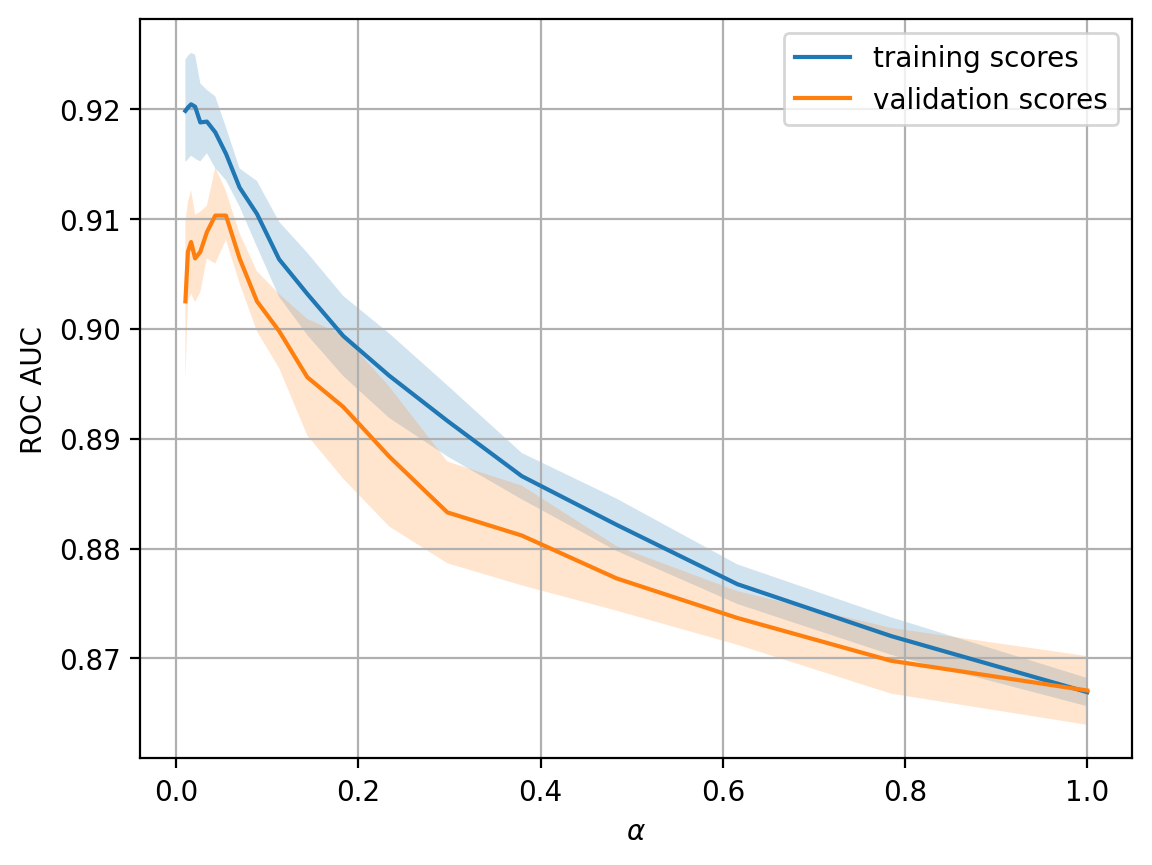

In [7]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )


plot_with_err(alphas, val_train, label="training scores")
plot_with_err(alphas, val_test, label="validation scores")
plt.xlabel(r"$\alpha$")
plt.ylabel("ROC AUC")
plt.legend()
plt.grid(True);

The trend is quite visible and is very common.

- For simple models, training and validation errors are close and large. This suggests that the model underfitted, meaning it does not have a sufficient number of parameters.

- For highly sophisticated models, training and validation errors differ significantly. This can be explained by overfitting. When there are too many parameters or regularization is not strict enough, the algorithm can be “distracted” by the noise in the data and lose track of the overall trend.

## How much data is needed?
The more data the model uses, the better. But how do we understand whether new data will helpful in any given situation? For example, is it rational to spend $N$ for assessors to double the dataset?

Since the new data can be unavailable, it is reasonable to vary the size of the training set and see how the quality of the solution depends on the amount of training data. This is how we get learning curves.

The idea is simple: we display the error as a function of the number of examples used in training. The parameters of the model are fixed in advance.

In [8]:
def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=degree)),
            (
                "sgd_logit",
                SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha, max_iter=5),
            ),
        ]
    )
    N_train, val_train, val_test = learning_curve(
        logit_pipe, X, y, train_sizes=train_sizes, cv=5, scoring="roc_auc"
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True);

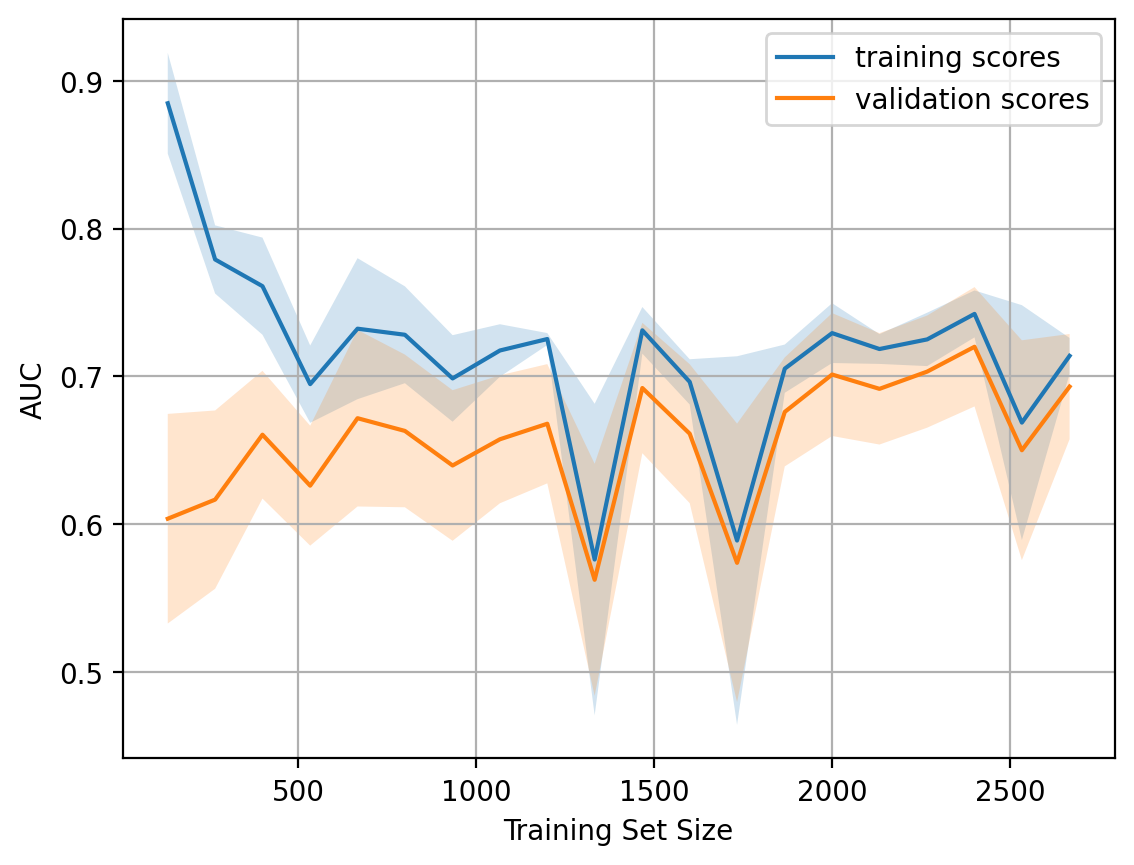

In [9]:
%%capture --no-display
plot_learning_curve(degree=2, alpha=10)

A typical situation: for a small amounts of data, errors between training and cross-validation sets are quite different, indicating overfitting. For that same model but with a large amount of data, errors “converge”, indicating underfitting.

If we add more data, error on the training set will not grow. On the other hand, the error on the test data will not be reduced.

So, we see that the errors “converged”, and the addition of new data will not help. Actually this case is the most interesting for business. It is possible that we increase the size of the dataset by 10x, but, without changing the complexity of the model, this additional data may not help. Therefore the strategy of “set once, then use 10 times” might not work.

What happens if we reduce the regularization coefficient to 0.05?

We see a good trend - the curves gradually converge, and if we move farther to the right i.e. add more data to the model, we can improve the quality on the validation set even more.

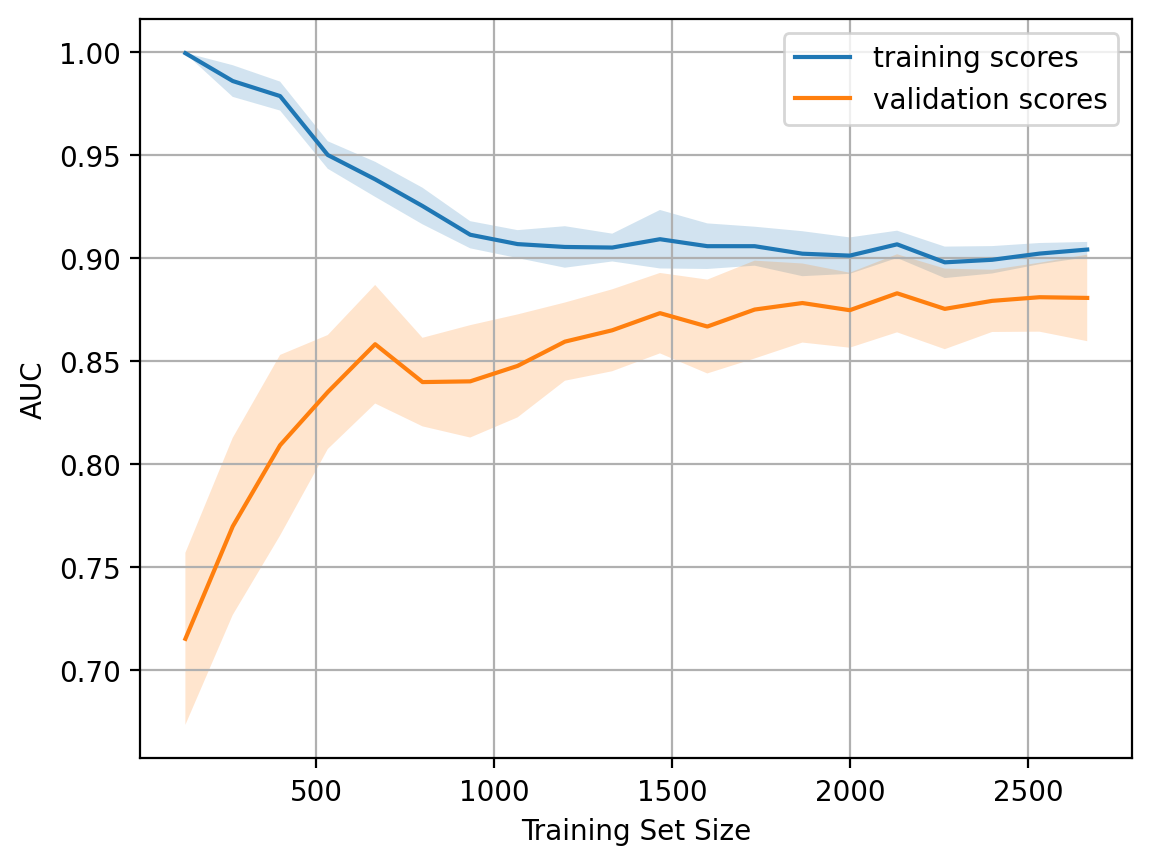

In [11]:
%%capture --no-display
plot_learning_curve(degree=2, alpha=0.05)

Constructing these curves can help understand which way to go and how to properly adjust the complexity of the model for new data.

Conclusions on the learning and validation curves:

- Error on the training set says nothing about the quality of the model by itself

- Cross-validation error shows how well the model fits the data (the existing trend in the data) while retaining the ability to generalize to new data

- Validation curve is a graph showing the results on training and validation sets depending on the complexity of the model:

    - if the two curves are close to each other and both errors are large, it is a sign of underfitting

    - if the two curves are far from each other, it is a sign of overfitting

- Learning Curve is a graph showing the results on training and validation sets depending on the number of observations:

    - if the curves converge, adding new data won’t help, and it is necessary to change the complexity of the model

    - if the curves have not converged, adding new data can improve the resultConstructing these curves can help understand which way to go and how to properly adjust the complexity of the model for new data.